In [1]:
from typing import Dict, List, Tuple

import random
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch_mlir
from torch_mlir import TensorPlaceholder

import iree.compiler as ireec
import iree.runtime as ireert


In [2]:
def approximate_machine_peak_gflops_f32():
    """Return a GFLOPS(f32) number near the machine peak.
    
    We count one "multiply-add" as a "flop". Sometimes people count it as two
    but that adds "off by two" errors everywhere.
    """
    M, K, N = 2096, 2096, 2096
    lhs, rhs = torch.ones(M, K), torch.ones(K, N)
    # Take the max of a few runs.
    # Since we only care about the absolute max of the chip, discarding
    # lower values make sense.
    max_gflops_observed = 0
    for _ in range(10):
        ns_begin = time.perf_counter_ns()
        torch.matmul(lhs, rhs)
        ns_end = time.perf_counter_ns()
        s_elapsed = (ns_end - ns_begin) / 1e9
        flops = M * K * N
        gflops = (flops / s_elapsed) / 1e9
        max_gflops_observed = max(max_gflops_observed, gflops)
    return max_gflops_observed
MACHINE_PEAK_GFLOPS_F32 = approximate_machine_peak_gflops_f32()
print(f"Machine peak is estimated to be {MACHINE_PEAK_GFLOPS_F32:.2f} GFLOPS(f32)")

Machine peak is estimated to be 369.97 GFLOPS(f32)


In [3]:
def benchmark_matmul(
    mkn: Tuple[int, int, int],
    mkn_dynamic: Tuple[bool, bool, bool],
    run_duration_sec=5,
    max_samples=50,
):
    m, k, n = mkn
    m_dynamic, k_dynamic, n_dynamic = mkn_dynamic
    class MatmulModule(torch.nn.Module):
        def forward(self, lhs, rhs):
            return torch.matmul(lhs, rhs)

    lhs_placeholder = TensorPlaceholder([
        -1 if m_dynamic else m,
        -1 if k_dynamic else k,
    ], dtype=torch.float32)
    rhs_placeholder = TensorPlaceholder([
        -1 if k_dynamic else k,
        -1 if n_dynamic else n,
    ], dtype=torch.float32)

    linalg_module = torch_mlir.compile(
        MatmulModule(),
        (lhs_placeholder, rhs_placeholder),
        output_type="linalg-on-tensors",
    )
    vmfb = ireec.compile_str(str(linalg_module), target_backends=["llvm-cpu"])
    config = ireert.Config(driver_name="local-task")
    ctx = ireert.SystemContext(config=config)
    vm_module = ireert.VmModule.from_flatbuffer(ctx.instance, vmfb)
    ctx.add_vm_module(vm_module)

    iree_module = ctx.modules.module

    lhs_torch = torch.randn(m, k)
    rhs_torch = torch.randn(k, n)
    
    lhs = ireert.asdevicearray(iree_module._context.config.device, lhs_torch.numpy())
    rhs = ireert.asdevicearray(iree_module._context.config.device, rhs_torch.numpy())
    
    # Correctness check. This also is a warmup run.
    iree_result = iree_module["forward"](lhs, rhs)
    dst = torch.from_numpy(np.asarray(iree_result))
    if not torch.allclose(dst, MatmulModule().forward(lhs_torch, rhs_torch), rtol=1e-03, atol=1e-03):
        raise Exception(f">>> ALL BENCHMARKING NUMBERS INVALID ({m}, {k}, {n}) -- incorrect result computed! <<<")

    overall_benchmarking_start_sec = time.monotonic()

    gflops_per_run = []
    while len(gflops_per_run) < max_samples and \
        time.monotonic() - overall_benchmarking_start_sec < run_duration_sec:

        ns_begin = time.perf_counter_ns()
        iree_result = iree_module["forward"](lhs, rhs)
        ns_end = time.perf_counter_ns()
        ns_elapsed = ns_end - ns_begin
        flops = n * k * m
        s_elapsed = ns_elapsed / 1e9
        gflops_per_run.append((flops / s_elapsed) / 1e9)
    
    assert len(gflops_per_run) > 0
    return gflops_per_run


In [4]:
# A set of round sizes to run matmul benchmarks on.
BASELINE_SIZES = [
    32, 64, 96,
    128, 192, 256, 384,
    512, 1024,
    1536, 2048, 3072, 4096
]
# Ensure the baseline sizes are all nice and round.
# We will test "size - 1" and "size + 1" separately
# by modifying these numbers.
assert all(size % 32 == 0 for size in BASELINE_SIZES)

In [5]:
def benchmark_NxNxN(matmul_sizes):
    benchmark_results: Dict[int, List[int]] = {}
    for size in matmul_sizes:
        benchmark_results[size] = benchmark_matmul(
            mkn=(size, size, size), mkn_dynamic=(False, False, False))

    sizes = []
    gflops = []
    for size, gflops_of_runs in benchmark_results.items():
        for gflops_of_run in gflops_of_runs:
            sizes.append(size)
            gflops.append(gflops_of_run)
    return pd.DataFrame(data={"size": sizes, "gflops": gflops})

In [6]:
df = benchmark_NxNxN(BASELINE_SIZES)

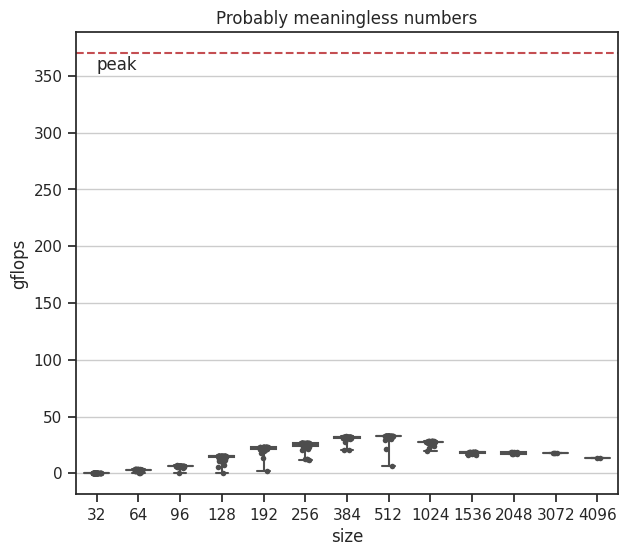

In [7]:
# Inspired by: https://seaborn.pydata.org/examples/horizontal_boxplot.html
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(7, 6))

sns.boxplot(x="size", y="gflops", data=df, orient="v",
    whis=[0, 100], width=.6, palette="vlag")

sns.stripplot(x="size", y="gflops", data=df, orient="v",
    size=4, color=".3", linewidth=0)

ax.axline(
    [0, MACHINE_PEAK_GFLOPS_F32],
    [1, MACHINE_PEAK_GFLOPS_F32],
    color="r", linestyle="--")
ax.text(0, MACHINE_PEAK_GFLOPS_F32 * 0.96, "peak")
ax.yaxis.grid(True)
ax.set_title("Probably meaningless numbers")
None